## Load Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from typing import Any, Callable, Dict, List, Optional, Tuple
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Define the Dataset Class
Here MyDataset consists of using <br>
#### Inputs and Data Representation <br>
* Images from the MNIST dataset
* A random number between 0 and 9 (represented as one hot encoded data) <br>
#### Targets and Data Representation<br>
* the "number" that was represented by the MNIST image
* The "sum" of the MNIST number with the random number (not one hot encoded)
#### Methods used
The random number is generated using torch.randint and limited to 10 numbers.
Inheriting from the torchvision.datasets.MNIST to use existing methods to load, download MNIST data to the system.

In [2]:
class MyDataset(torchvision.datasets.MNIST):
    """Inherit from the MNIST class to be able to download, 
    send MNIST data and create a random number between 0 and 9"""
    def __init__(self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,):
        super(MyDataset, self).__init__(root, download = download, transform=transform,target_transform=target_transform)
        self.rand = 0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        # Random number
        self.rand = torch.randint(low=0,high=10,size=(1,))
        one_hot = torch.nn.functional.one_hot(self.rand, num_classes=10)
        sum = target + self.rand
        return [img,one_hot], [target, sum]

    def __len__(self):
        return len(self.data)

## Define the Datasets, DataLoaders, device

In [3]:
# Device is auto selected as cgpu if available but code will still run in the absence of gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Dataset train object created from custom MyDataset class
train_set = MyDataset(root = './data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
# Train loader is used to load the images in batches and shuffle them for training
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)

inputs, targets = next(iter(train_loader))
images, number = inputs

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Display image and labels for verification
Displaying 16 images but batch size is kept higher for faster training

Ground Truth Image Labels are tensor([7, 1, 3, 9, 8, 7, 1, 1, 5, 2, 2, 3, 9, 7, 3, 8])
random number input is tensor([8, 4, 8, 1, 2, 8, 4, 9, 3, 1, 2, 5, 4, 1, 1, 0])
Sum output is tensor([15,  5, 11, 10, 10, 15,  5, 10,  8,  3,  4,  8, 13,  8,  4,  8])


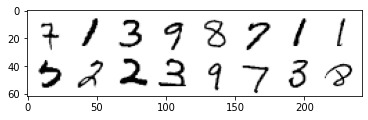

In [4]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

grid = torchvision.utils.make_grid(images[:16])
matplotlib_imshow(grid, one_channel=True)
print("Ground Truth Image Labels are", targets[0][:16])
print("random number input is", number.squeeze().argmax(dim=1)[:16])
print("Sum output is", targets[1].squeeze()[:16])

## Define the Deep Learning model
* Here for the MNIST we have a conv block and a classifier block
* Next the output of this MNIST is taken along with the random number into the mix block to generate the sum output

In [6]:
class MyModule(torch.nn.Module): #94%
    def __init__(self, num_classes=10):
        super(MyModule, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5), #28 -> 24
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5), #24 -> 20
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=10, kernel_size=1), # 20*20*10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 10*10*10
        )
        self.classifier = nn.Sequential(
              torch.nn.Linear(1000, 512, bias = True),
              nn.BatchNorm1d(512),
              nn.ReLU(),
              torch.nn.Linear(512, 256, bias = True),
              nn.BatchNorm1d(256),
              nn.ReLU(),
              torch.nn.Linear(256, 10, bias = True),
              )
        self.mix = nn.Sequential(
            torch.nn.Linear(20,50, bias = True),
            nn.ReLU(),
            nn.Linear(50,20, bias = True),
        )

    def forward(self, x, num):
        x = self.conv(x)
        x1 = torch.flatten(x,start_dim=1)
        mnist = self.classifier(x1) 
        sum_in = torch.cat((mnist, num), dim=1)
        n = self.mix(sum_in)
        return mnist, n

net = MyModule().to(device)

## Start Training Loop
2 Loss functions used seperately because these are 2 seperate outputs with crossentropy ( Softmax+ NLL)

In [8]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.CrossEntropyLoss()
net.train()
# loop over the dataset multiple times
for epoch in range(5):
    running_loss = 0.0
    correct_pred = 0
    correct_rand = 0
    for i, batches in enumerate(train_loader, 0):
        inputs, targets = batches
        images, number = inputs
        labels, num_truth = targets
        number, num_truth = number.squeeze().type(torch.float32), num_truth.squeeze().type(torch.float32)
        inputs, labels, number, num_truth = images.to(device), labels.to(device), number.to(device), num_truth.to(device).long()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, n = net(inputs, number)

        one_hot_labels = F.one_hot(torch.tensor(labels.int()).long(), num_classes=10)
        one_hot_truth = F.one_hot(torch.tensor(num_truth.int()).long(), num_classes=20)

        loss1 = criterion1(outputs, labels)
        loss2 = criterion2(n, num_truth) 
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss1.item() + loss2.item()
        # Accuracy
        correct_pred += outputs.argmax(dim=1).eq(labels.squeeze().to(device)).sum()
        correct_rand += n.argmax(dim=1).eq(num_truth).sum()
        accuracy = (correct_pred/((i+1)*len(inputs)))
        accuracy_rand = (correct_rand/((i+1)*len(num_truth)))
        
        if i % 100 == 0:
          print(f"epoch: {epoch} train loss: {(running_loss/(i+1)):.4f} mnist_accuracy: {(accuracy):.2f} rand_acc: {(accuracy_rand):.2f}")
    print('Loss: {}'.format(running_loss/len(train_set)))

print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 train loss: 5.3513 mnist_accuracy: 0.11 rand_acc: 0.08
epoch: 0 train loss: 2.9840 mnist_accuracy: 0.91 rand_acc: 0.11
epoch: 0 train loss: 2.7382 mnist_accuracy: 0.94 rand_acc: 0.12
epoch: 0 train loss: 2.6110 mnist_accuracy: 0.95 rand_acc: 0.14
epoch: 0 train loss: 2.5201 mnist_accuracy: 0.96 rand_acc: 0.16
Loss: 0.019246196446971345
epoch: 1 train loss: 2.0617 mnist_accuracy: 0.98 rand_acc: 0.30
epoch: 1 train loss: 1.9656 mnist_accuracy: 0.99 rand_acc: 0.40
epoch: 1 train loss: 1.8766 mnist_accuracy: 0.99 rand_acc: 0.44
epoch: 1 train loss: 1.7779 mnist_accuracy: 0.99 rand_acc: 0.50
epoch: 1 train loss: 1.6756 mnist_accuracy: 0.99 rand_acc: 0.55
Loss: 0.012565091489274831
epoch: 2 train loss: 1.1643 mnist_accuracy: 0.98 rand_acc: 0.79
epoch: 2 train loss: 1.0400 mnist_accuracy: 0.99 rand_acc: 0.85
epoch: 2 train loss: 0.9504 mnist_accuracy: 0.99 rand_acc: 0.88
epoch: 2 train loss: 0.8686 mnist_accuracy: 0.99 rand_acc: 0.90
epoch: 2 train loss: 0.7950 mnist_accuracy: 0.99 r

## Create the Test Dataset

In [9]:
# Dataset test object created from custom MyDataset class
test_set = MyDataset(root = './data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
# Train loader is used to load the images in batches and shuffle them for training
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=True)

inputs, targets = next(iter(test_loader))
images, number = inputs

## Run Test Loop to print Accuracy

In [20]:
# Testing the model
net.eval()
with torch.no_grad():
    correct_pred = 0
    correct_rand = 0
    total = 0
    total_losss =0
    for batches in test_loader:
        inputs, targets = batches
        images, number = inputs
        labels, num_truth = targets
        number, num_truth = number.squeeze().type(torch.float32), num_truth.squeeze().type(torch.float32)
        inputs, labels, number, num_truth = images.to(device), labels.to(device), number.to(device), num_truth.to(device).long()

        outputs, n = net(inputs, number)
        total += labels.size(0)
        # Accuracy
        correct_pred += outputs.argmax(dim=1).eq(labels.squeeze().to(device)).sum()
        correct_rand += n.argmax(dim=1).eq(num_truth).sum()
        accuracy = (correct_pred/((i+1)*len(inputs)))
        accuracy_rand = (correct_rand/((i+1)*len(num_truth)))
    print('Test Accuracy of the MNIST: {} %'.format(correct_pred / total))
    print('Test Accuracy of the random number: {} %'.format(correct_rand / total))

Test Accuracy of the MNIST: 0.9934333562850952 %
Test Accuracy of the random number: 0.9886500239372253 %
